In [1]:
pwd

'/Users/andrewemmett/Projects/nf-kurs-2020/nairobi-capstone/Notebooks'

In [2]:
import sys
sys.path.append('../Scripts')
from capstone_functions import *

In [3]:
def ambulance_placement_pipeline_1(input_path='../Inputs/', output_path='../Outputs/', crash_source_csv='Train',
                                 outlier_filter=0,
                                 holdout_strategy='year_2019', holdout_test_size=0.3,
                                 test_period_date_start='2019-01-01', test_period_date_end='2019-07-01',
                                 tw_cluster_strategy='saturday_2', placement_method='k_means', verbose=0,
                                 lr=3e-2, n_epochs=400, batch_size=50):  
    '''
    load crash data (from train or prediction) and apply feautre engineering, run tw clustering (based on strategy choice) 
    create ambulance placements, create output file.
    placement_model has no impact on functions but is used to add info to output file
    '''
    # load crash data into dataframe
    crash_df = create_crash_df(train_file = input_path+crash_source_csv+'.csv')
    if 'latitude' not in crash_df.columns:
        crash_df['latitude'] = crash_df.hex_bins.apply(lambda x : h3.h3_to_geo(x)[0])
        crash_df['longitude'] = crash_df.hex_bins.apply(lambda x : h3.h3_to_geo(x)[1])  
        crash_df = crash_df.drop("hex_bin", axis=1)
    
    # create individual date and time features from date column
    crash_df = create_temporal_features(crash_df)
    
      
    # split data into train and test sets
    train_df, test_df = split_accident_df(data=crash_df, strategy=holdout_strategy,
                                          test_size=holdout_test_size)
    
    # remove outliers from test set based on lat and lon
    train_df = outlier_removal(train_df, filter=outlier_filter)
    # apply time window cluster labels to df based on strategy specified
    train_df = create_cluster_feature(train_df, strategy=tw_cluster_strategy, verbose=verbose)
    # Run clustering model to get placement set centroids for each TW cluster
    test_df_with_clusters = create_cluster_feature(test_df, strategy=tw_cluster_strategy, verbose=0)
    centroids_dict = create_cluster_centroids(train_df, test_df=test_df_with_clusters, verbose=verbose, method=placement_method,
                                             lr=lr, n_epochs=n_epochs, batch_size=batch_size)
    

    # create df in format needed for submission
    train_placements_df = centroid_to_submission(centroids_dict, date_start='2018-01-01', date_end='2019-12-31',
                                                 tw_cluster_strategy=tw_cluster_strategy)
    
    # Run scoring functions
    if verbose > 0:    
        print(f'Total size of test set: {test_df.shape[0]}')
    test_score = score(train_placements_df, test_df, test_start_date=test_period_date_start,
                       test_end_date=test_period_date_end)
    if verbose > 0:    
        print(f'Total size of train set: {crash_df.shape[0]}')
    train_score = score(train_placements_df,train_df,
                        test_start_date=test_period_date_start, test_end_date=test_period_date_end)
    if verbose > 0:    
        print(f'Score on test set: {test_score / max(test_df.shape[0],1)}')
    if verbose > 0:    
        print(f'Score on train set: {train_score / train_df.shape[0] } (avg distance per accident)')

    # Create file for submitting to zindi
    submission_df = centroid_to_submission(centroids_dict, date_start='2019-07-01', date_end='2020-01-01',
                                           tw_cluster_strategy=tw_cluster_strategy)
    create_submission_csv(submission_df, crash_source=crash_source_csv, outlier_filter=outlier_filter,
                          tw_cluster_strategy=tw_cluster_strategy, placement_method=placement_method, path=output_path)


1 clusters created
using k-medoids clustering


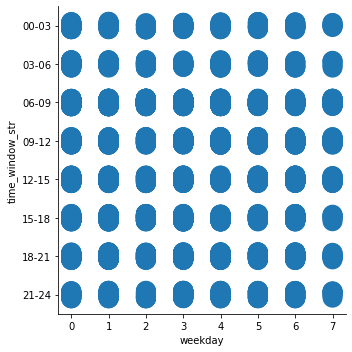

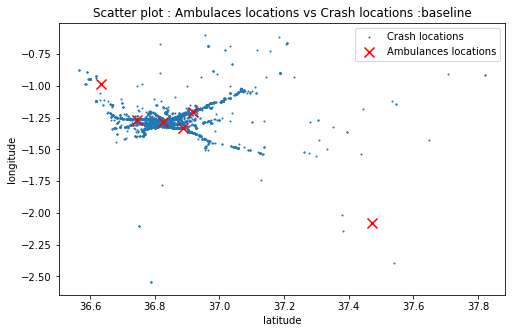

[[-1.28403021 36.8254564 ]
 [-1.20361355 36.9173289 ]
 [-2.07987511 37.4730188 ]
 [-1.33143607 36.88852577]
 [-1.26662371 36.7464754 ]
 [-0.98337461 36.6323335 ]]
1 placement sets created
Total size of test set: 1895
Total size of train set: 6318
Score on test set: 0.055050949895296
Score on train set: 0.053412504277342523 (avg distance per accident)


In [6]:
ambulance_placement_pipeline_1(input_path='../Inputs/', output_path='../Outputs/', crash_source_csv='Train',
                             # outlier_filter=0.005, 
                             holdout_strategy='random', holdout_test_size=0.3,
                             test_period_date_start='2018-01-01', test_period_date_end='2019-12-31',
                             tw_cluster_strategy='baseline', placement_method='k_medoids', verbose=10,
                             lr=1e-2, n_epochs=400)


In [6]:
# load crash data into dataframe
input_path='../Inputs/'
crash_source_csv='predictions_for_clustering_b'
crash_df = create_crash_df(train_file = input_path+crash_source_csv+'.csv')
# create individual date and time features from date column
crash_df = create_temporal_features(crash_df)
crash_df['latitude'] = crash_df.hex_bins.apply(lambda x : h3.h3_to_geo(x)[0])
crash_df['longitude'] = crash_df.hex_bins.apply(lambda x : h3.h3_to_geo(x)[1])    

In [7]:
crash_df.tail()

,datetime,hex_bins,time,time_window,time_window_str,day,weekday,month,half_year,rainy_season,year,date_trunc,holiday,latitude,longitude
4222,2019-06-29 18:01:00,867a6e467ffffff,18:01:00,7,18-21,29,5,Jun,1,0,2019,2019-06-29,0,-1.280166,36.712630
4223,2019-06-30 09:01:00,867a6e42fffffff,09:01:00,4,09-12,30,6,Jun,1,0,2019,2019-06-30,0,-1.265393,36.817341
4224,2019-06-30 12:01:00,867a6e557ffffff,12:01:00,5,12-15,30,6,Jun,1,0,2019,2019-06-30,0,-1.325297,36.827700
4225,2019-06-30 15:01:00,867a6e42fffffff,15:01:00,6,15-18,30,6,Jun,1,0,2019,2019-06-30,0,-1.265393,36.817341
4226,2019-06-30 18:01:00,867a6e417ffffff,18:01:00,7,18-21,30,6,Jun,1,0,2019,2019-06-30,0,-1.190764,36.911613


In [16]:
#crash_df.hex_bins[0]
h3.h3_to_geo(crash_df.hex_bins[0])

(-1.1907643426934362, 36.91161284376856)

In [23]:
crash_df['longitude']

0       36.911613
1       37.199105
2       36.911613
3       36.817341
4       37.199105
          ...    
4222    36.712630
4223    36.817341
4224    36.827700
4225    36.817341
4226    36.911613
Name: longitude, Length: 4227, dtype: float64

In [8]:
h3.h3_distance(867a6e417ffffff,867a6e42fffffff)

SyntaxError: invalid syntax (<ipython-input-8-42070fec0d00>, line 1)